# Cvičení 04 - k-nejbližších sousedů (kNN)

V tomto cvičení se budeme zabývat metodou $k$-nejbližších sousedů pro klasifikaci i regresi.
V regresním případě si můžeme princip metody představit na tomto obrázku:

<center><img src="img/knn.svg" width="10%"></center>
<center>(zdroj: https://commons.wikimedia.org/wiki/File:KnnClassification.svg, autor: Antti Ajanki)</center>


Jde o to, využít vhodnou metriku (vzdálenost) k nalezení $k$-nejbližších sousedů a poté z jejich hodnot cílové proměnné predikovat cílovou proměnnou pro náš bod.

### Hyperparametry:
- $k$ - počet nejbližších sousedů (např. 5),
- **vzdálenost** - nejčastěji Eukleidovská metrika,
- **vážení** - zda při výpočtu nejčetnější hodnoty (klasifikace) nebo průměrné hodnoty (regrese) používat vážení, a jaké případně využít (např. převrácenou hodnotou vzdálenosti).

In [1]:
import math
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Klasifikace Iris datasetu

V této části se budemě věnovat klasifikační úloze na standardním datasetu **Iris**
[https://en.wikipedia.org/wiki/Iris_flower_data_set](https://en.wikipedia.org/wiki/Iris_flower_data_set)
Teto dataset obsahuje záznamy o šířkách a délkách korunních (petal) a kališních (sepal) lístků kosatců. V datasetu se vyskytují tři druhy kosatců (setosa, versicolor a virginica) a cílem je klasifikovat na základě těchto 4 příznaků o jaký druh se jedná.

<center><img src="img/iris-dataset.png" width="50%"></center>
<center>(zdroj: https://machinelearninghd.com/iris-dataset-uci-machine-learning-repository-project/)</center>

<center><img src="img/iris_measurements.png" width="10%"></center>
<center>(zdroj: https://kedro.readthedocs.io/en/0.17.5/02_get_started/05_example_project.html)</center>

Dataset načteme pomocí modulu `sklearn.datasets`. 
Práci si ale trochu ztížíme a první příznak převedeme na milimetry.

In [98]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

print(f"Načtené rozměry, X: {X.shape}, y: {y.shape}")

print('Ukázka dat:')
display(X[:5,:])

Načtené rozměry, X: (150, 4), y: (150,)
Ukázka dat:


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [99]:
# Převedeme první příznak z centimetrů na milimetry
X[:, 0] *= 10

print(f"Rozměry, X: {X.shape}, y: {y.shape}")
print('Ukázka dat:')
display(X[:5,:])

Rozměry, X: (150, 4), y: (150,)
Ukázka dat:


array([[51. ,  3.5,  1.4,  0.2],
       [49. ,  3. ,  1.4,  0.2],
       [47. ,  3.2,  1.3,  0.2],
       [46. ,  3.1,  1.5,  0.2],
       [50. ,  3.6,  1.4,  0.2]])

Pomocí již dobře známé funkce `train_test_split` rozdělíme data na trénovací a validační v poměru 60:20:20:

In [100]:
random_seed = 42

Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.5, random_state=random_seed)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.5, random_state=random_seed)

print(f"Train rozměry, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Val rozměry, X: {Xval.shape}, y: {yval.shape}")
print(f"Test rozměry, X: {Xtest.shape}, y: {ytest.shape}")

Train rozměry, X: (75, 4), y: (75,)
Val rozměry, X: (37, 4), y: (37,)
Test rozměry, X: (38, 4), y: (38,)


Data si můžeme vizualizovat pomocí scatter plotu. Vidíme, že dvě ze tříd se mírně překrývají. To by ale pro kNN klasifikátor (např. oproti lineární separaci) neměl být problém.

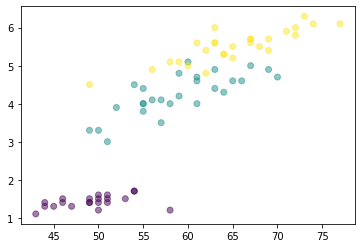

In [101]:
plt.scatter(Xtrain[:, 0], Xtrain[:, 2], c=ytrain, alpha=0.5)
plt.show()

Jak ale uvidíme za chvíli, kNN je velice citlivé na různě velké rozsahy hodnot jednotlivých příznaků.

### Úkol: Ruční implementace KNN

Zkusme si vlastní implementaci metody nejbližších sousedů. Pro jednoduchost použijeme Eukleidovskou metriku a nebudeme dělat žádné vážení.

Hint: Použijte `numpy.argpartition` a `scipy.stats.mode`.

In [102]:
def knn_predict(X, k, Xtrain, ytrain):
    """
    X je matice M x p kde pro každý z M bodů chceme na základě p příznaků predikovat
    k je počet nejbližších sousedů
    Xtrain je N x p matice trénovacích bodů a ytrain je vektor p hodnot vysvětlované proměnné
    
    vrací vektor predikcí o délce M 
    """
    y = np.zeros((X.shape[0],), np.int32)
    # Váš kód zde
    
    # - vyrobíme matici vzdáleností x_i od xtr_j (itý pro predikci od jtého z trénovací množiny)
    D = np.zeros((X.shape[0], Xtrain.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Xtrain.shape[0]):
            D[i,j] = np.linalg.norm(X[i,:] - Xtrain[j,:])
    
    # najdeme pro každý bod k nejbližších sousedů a provedeme predikci
    for i in range(X.shape[0]):
        # indexy nejbližších sousedů
        idx = np.argpartition(D[i,:], k)
        # hodnoty y nejbližších sousedů
        neigh_y = ytrain[idx[:k]]
        # predikce pomocí nejčastější hodnoty
        y[i] = stats.mode(neigh_y).mode[0]
        # print(idx[:k])
        # print(D[i,idx[:k+4]])
        # print(neigh_y)
        # print(stats.mode(neigh_y).mode[0])
        # break
    return y

# provedeme predikci
y_pred = knn_predict(Xval, 5, Xtrain, ytrain)

# Ověříme přesnost na validační množině
print(f"Validation accuracy: {metrics.accuracy_score(yval, y_pred)}")

Validation accuracy: 0.8378378378378378


Získali jsme rozumný výsledek. Pro větší data, ale naše implementace nebude výpočetně příliš optimální. Zkusme si tedy nyní to samé provést pomocí standardní knihovny ze `sklearn` a ověřme, že dostaneme stejný výsledek.

### Implementace KNeighborsClassifier ve scikit
Nyní použijeme `KNeighborsClassifier` z knihovny `sklearn`.

In [103]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(Xtrain, ytrain)
print(f"Validation accuracy: {metrics.accuracy_score(yval, clf.predict(Xval)):0.4f}")

Validation accuracy: 0.8378


Dostali jsme stejný výsledek, jako naší _ruční_ implementací! 

V obou případech ale přesnost bohužel příliš vysoká.
Pojďme se nyní zaměřit na vliv přeškálování prvního příznaku, které jsme provedli na začátku.

Zkusme nejprve celý postup zreplikovat bez toho **poškození**.

In [107]:
import copy
Xtrain_clean = copy.deepcopy(Xtrain)
Xtrain_clean[:, 0] *= 0.1

Xval_clean = copy.deepcopy(Xval)
Xval_clean[:, 0] *= 0.1

print('Ukázka dat:')
display(Xtrain_clean[:5,:])

clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(Xtrain_clean, ytrain)
print(f"Validation accuracy: {metrics.accuracy_score(yval, clf.predict(Xval_clean)):0.4f}")

Ukázka dat:


array([[5.4, 3. , 4.5, 1.5],
       [6.2, 3.4, 5.4, 2.3],
       [5.5, 2.3, 4. , 1.3],
       [5.4, 3.9, 1.7, 0.4],
       [5. , 2.3, 3.3, 1. ]])

Validation accuracy: 0.8919


Vidíme, že jsme dostali lepší výsledek. Prvotní převedení prvního příznaku do milimetrů tedy z hledika predikce uškodilo.

### Normalizace dat
Zkusme si nyní obecný přístup, který více odpovídá realitě, kdy _poškození_ dat nemůžeme prostě vrátit. 

Na přednášce jsme si říkali, že pro _narovnání_ číselných rozsahů jednotlivých příznaků může mít smysl použít normalizaci.

Zkusíme si tedy nyní **min-max normalizaci**. To v Pythonu uděláme pomocí třídy `MinMaxScaler` z modulu `sklearn.preprocessing`.

In [108]:
from sklearn.preprocessing import MinMaxScaler

# Min-max scaler nafitujeme na trénovacích datech
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

# Následně stejnou transformaci aplikujeme i na validační data
Xval_scaled = scaler.transform(Xval)

# Natrénujeme model na transformovaných datech
clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled, ytrain)

print(f"Validation accuracy of normalized model: {clf.score(Xval_scaled, yval):0.4f}")

Validation accuracy of normalized model: 0.9189


Taková přesnost už je velice pěkná. Pojďme si ještě vyzkoušet **standardizaci** jako další z používaných typů normalizace.

In [85]:
from sklearn.preprocessing import StandardScaler

# Min-max scaler nafitujeme na trénovacích datech
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)

# Následně stejnou transformaci aplikujeme i na validační data
Xval_scaled = scaler.transform(Xval)

# Natrénujeme model na transformovaných datech
clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled, ytrain)

print(f"Validation accuracy of normalized model: {clf.score(Xval_scaled, yval):0.4f}")

Validation accuracy of normalized model: 0.9189


Vidíme, že jsme dostali totožný výsledek. To v praxi nemusí být vždy tak. Jeden nebo druhý (nebo) žádný způsob normalizace může dávat lepší výsledky.

### Úkol: podívejte se nyní na vliv hyperparametrů na výkonnost predikce

Zaměřte se především na parametr $k$

In [119]:
val_acc = []
train_acc = []

kneighbors = ...

# Váš kód zde
kneighbors = range(3,15)
for k in kneighbors:
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(Xtrain_scaled, ytrain)
    val_acc.append(clf.score(Xval_scaled, yval))
    train_acc.append(clf.score(Xtrain_scaled, ytrain))

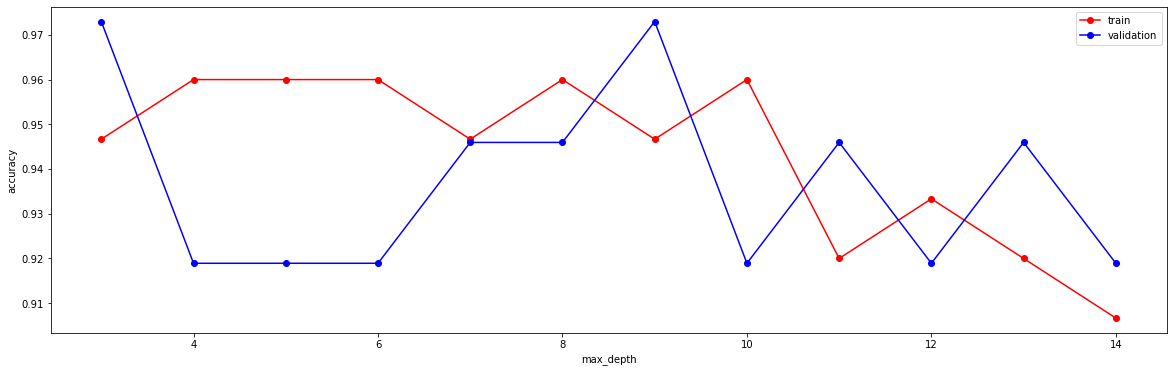

In [120]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(kneighbors, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(kneighbors, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

### Pár bodů k zamyšlení

- Člověka by mohlo napadnout provést normalizaci na celém trénovacím datasetu a až potom provádět validaci. V tu chvíli by ale validační chyba nebyla objektivní. (Je to podobné, jako bychom při trénování používali i testovací data.)
- Min-max normalizace, případně standardizace není všespásná, jedná se o obyčejnou lineární transformaci. Obecně jí dělají problém odlehlé hodnoty (outlieři). V tu chvíli je vhodné buď outliery nejprve odstranit, nebo použít robustnější metodu normalizace.

## Regresní úloha s datasetem house prices

Nyní se podívejme na predikci spojité vysvětlované proměnné u datasetu house prices.

Metodu kNN nelze přímo použít, pokud máme v datasetu jiné než číselné příznaky.
Protože, jsme s tímto datasetem již pracovali, pro urychlení přebereme základní předzpracování z přechozího cvičení.

V prvním přiblížení použijeme na nominální příznaky **one-hot encoding**

In [178]:
def get_houses_dataset(one_hot = True, fill_na = True):
    df = pd.read_csv('house-prices-train.csv')

    qual_category = pd.api.types.CategoricalDtype(categories=['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
    for col in df.select_dtypes('object').columns:
        if col.endswith("Qual") or col.endswith("Qu") or col.endswith("QC") or col.endswith("Cond"):
            df[col] = df[col].astype(qual_category)

    for col in df.select_dtypes('category').columns:
        df[col] = df[col].cat.codes

    # ONE-HOT encoding
    if one_hot:
        df = pd.get_dummies(df)
    # Missing values
    if fill_na:
        df = df.fillna('-1')
    return df

# načteme si dataset
df = get_houses_dataset()

# Split the training dataset into 60% train and 40% rest
Xtrain, Xrest, ytrain, yrest = train_test_split(df.drop(columns=['SalePrice']), df.SalePrice, test_size=0.4, random_state=random_seed)

# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(Xrest, yrest, test_size=0.6, random_state=random_seed)

print(f"Train rozměry, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Val rozměry, X: {Xval.shape}, y: {yval.shape}")
print(f"Test rozměry, X: {Xtest.shape}, y: {ytest.shape}")

Train rozměry, X: (876, 255), y: (876,)
Val rozměry, X: (351, 255), y: (351,)
Test rozměry, X: (233, 255), y: (233,)


Pro modelování použijeme implementaci `KNeighborsRegressor` ze `sklearn`. Než to ale uděláme, zkontrolujeme, že opravdu máme všude validní data

In [179]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

clf = KNeighborsRegressor(n_neighbors=5)
clf.fit(Xtrain, ytrain)

train_rmse_tree = mean_squared_error(ytrain, clf.predict(Xtrain), squared = False)
valid_rmse_tree = mean_squared_error(yval, clf.predict(Xval), squared = False)x`xx``x
print(f"RMSE (train): \t{train_rmse_tree:.0f}")
print(f"RMSE (valid): \t{valid_rmse_tree:.0f}")

RMSE (train): 	39289
RMSE (valid): 	52949


Pro porovnání si připomeňme hodnoty pro rozhodovací strom z minulého cvičení: 

RMSE (train): 23 963

RMSE (valid): 41 145

### Úkol: zkuste použít normalizaci, změnit počet nejbližších sousedů, případně jinou metriku

Diskutujte vliv jednotlivých operací

In [183]:
# Váš kód zde

df = get_houses_dataset()
# Split the training dataset into 60% train and 40% rest
Xtrain, Xrest, ytrain, yrest = train_test_split(df.drop(columns=['SalePrice']), df.SalePrice, test_size=0.4, random_state=random_seed)
# Split the rest of the data into 0.6*0.4=24% validation, 0.4*0.4=16% test
Xtest, Xval, ytest, yval = train_test_split(Xrest, yrest, test_size=0.6, random_state=random_seed)


# Scaler nafitujeme podle trénovacích dat a následně transformujeme i validační
scaler = MinMaxScaler()
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
Xval = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)

# Trénování
clf = KNeighborsRegressor(n_neighbors=5)
clf.fit(Xtrain, ytrain)

train_rmse_tree = mean_squared_error(ytrain, clf.predict(Xtrain), squared = False)
valid_rmse_tree = mean_squared_error(yval, clf.predict(Xval), squared = False)
print(f"RMSE (train): \t{train_rmse_tree:.0f}")
print(f"RMSE (valid): \t{valid_rmse_tree:.0f}")


# A další hraní

RMSE (train): 	35605
RMSE (valid): 	44289


## Prokletí dimenzionality

- Normalizovaná data jsou rozprostřena v $n$-rozměrné krychli o délce strany 1.
- Diagonála této krychle (za použití euklidovské vzdálenosti) měrí $\sqrt{n}$. To je zároveň nejvyšší možná vzdálenost, jakou mezi sebou dva body mohou mít.
- Prokletí dimenzionality znamená, že se zvyšující se dimenzí se vzdálenost k nejbližšímu sousedovi zvyšuje.
- Tento efekt můžeme poměrně dobře demonstrovat. Pro různé počty příznaků napočítáme poměr průměrné vzdálenosti k nejbližšímu sousedovi oproti diagonále krychle. (Dostáváme tedy vzdálenost relativní vůči maximální možné.) To samé můžeme spočítat i pro nejvzdálenější sousedy a pro průměr všech sousedů.

In [146]:
df = get_houses_dataset()
# Data pro jednoduchost rozdělíme na trénovací a validační
Xtrain, Xval, ytrain, yval = train_test_split(df.drop(columns=['SalePrice']), df.SalePrice, test_size=0.4, random_state=random_seed)

# Scaler opět nafitujeme podle trénovacích dat a následně transformujeme i validační
scaler = MinMaxScaler()
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)
Xval = pd.DataFrame(scaler.transform(Xval), index=Xval.index, columns=Xval.columns)

min_dist_ratio = []
max_dist_ratio = []
mean_dist_ratio = []
for n in range(1, 80 + 1):
    # Natrénujeme model pro různé počty příznaků
    model = KNeighborsRegressor(n_neighbors=10, p=2)
    model.fit(Xtrain.iloc[:, 0:n], ytrain)
    # Změříme vzdálenost pro všechny body z validační množiny
    dist, nn = model.kneighbors(Xval.iloc[:, 0:n])
    # Spočítáme průměrné vzdálenosti
    min_dist_ratio.append(np.mean(np.min(dist, axis=1)) / math.sqrt(n))
    max_dist_ratio.append(np.mean(np.max(dist, axis=1)) / math.sqrt(n))
    mean_dist_ratio.append(np.mean(np.mean(dist, axis=1)) / math.sqrt(n))

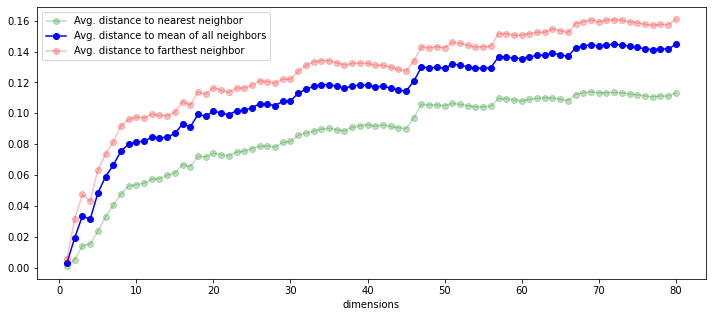

In [147]:
plt.figure(figsize=(12,5))
plt.xlabel('dimensions')
plt.plot(range(1, len(min_dist_ratio) + 1), min_dist_ratio, 'go-', alpha=0.25, label='Avg. distance to nearest neighbor')
plt.plot(range(1, len(mean_dist_ratio) + 1), mean_dist_ratio, 'bo-', label='Avg. distance to mean of all neighbors')
plt.plot(range(1, len(max_dist_ratio) + 1), max_dist_ratio, 'ro-', alpha=0.25, label='Avg. distance to farthest neighbor')
plt.legend()
plt.show()

*K zamyšlení: Proč křivka občas klesá? (Zkuste místo relativní vzdálenosti použít absolutní.)*

**Úkol:** Zkuste experimentovat s hyperparametrem `n_neighbors`. Jaký má jeho hodnota vliv na průměrnou vzdálenost? Vykreslete do jednoho grafu křivky pro více hodnot hyperparametru a porovnejte je.